In [1]:
import numpy as np
from qiskit import *
import math
from qiskit.quantum_info.operators import Operator
from qiskit import QuantumCircuit, QuantumRegister
from sympy import *
from math import pi
from qiskit.circuit import Parameter
%matplotlib inline
from scipy.integrate import odeint,solve_ivp
from qiskit.circuit.library.standard_gates import HGate

In [2]:
# Visualization packages
from qiskit.visualization import plot_state_city, plot_bloch_vector,plot_histogram, plot_bloch_multivector
import matplotlib.pyplot as plt

In [3]:
# Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')
backend_vec = Aer.get_backend('statevector_simulator')
backend_uni = Aer.get_backend('unitary_simulator')

In [4]:
# Register circuit (total qubits in the network)
q_1 = QuantumRegister(4)
c_1 = ClassicalRegister(4) 
qt = QuantumRegister(4)
ct = ClassicalRegister(4) 
qt2 = QuantumRegister(8)
ct2 = ClassicalRegister(8) 
# Register circuit (total qubits in the network)
q_2 = QuantumRegister(16) 
c_2 = ClassicalRegister(16)

In [5]:
#parameters
N_shots = 10240
N_time = 10000

# Using Quantum Circuits to solve Ordinary Differential Equations (Euler's Method)

Here we will use an algorithm from arXiv:2012.09469v1 "Quantum Algorithms for Solving Ordinary Differential Equations" by Zanger $\textit{et. al.}$

Consider the following Ordinary Differential Equation (ODE):

$$ \frac{d}{dt}u(t) =  k f(u(t)) =  \begin{pmatrix} u_2(t) \\ -u_1(t)\end{pmatrix}, $$

where k = 1.


Euler's method:
$u(t + \Delta t) \sim u(t) + k \Delta t f(u(t)) $ 


The algorithm they devised will take advantage of a  digital quantum computation.

Since each qubit represents two states 0 and 1, there is a total possibility of $2^n$ states to utilize if we have n amount of qubits. This means $| a \rangle = | a_{n-1} \rangle| a_{n-2} \rangle ...| a_0 \rangle$ in the binary representation. The number a can be broken down as a = $2^0a_0 + 2^1a_1 + ... + 2^{n-1}a_{n-1}$.

For an N-dimensional ODE, we want each component represent by $| a \rangle$. For example, $\vec{f}(\vec{u}(t)) \sim (u_1(t), u_2(t))^{\top}$ would mean that we need a register $| a' \rangle \rightarrow |u_1(t)\rangle, | b' \rangle \rightarrow |u_2(t)\rangle.$

## How to add two numbers

Let's consider that $\hat{X} |x\rangle$ yields a real number and $\hat{X}$ is the "position" operator. Its "momentum" conjugate is the fourier transform ($\hat{F}$) such that $\hat{P} = \hat{F}^{\dagger}\hat{X}\hat{F}$. We will assume $\hat{P} = \hat{H}$ where $\hat{H}$ is the Hamiltonian.


A continuous variable quantum state $| a \rangle$ is

$$ e^{-ic\hat{H}}|a\rangle  = | a + c \rangle \ \ \  (1)$$

where $\hat{H}$ is the Hamiltonian, and c is the shift in the Hamiltonian. 

For Eq. (1) to describe an integer interaction then, on a digital quantum computer schematic, we can take advantage of the FOurier transform

$$ \hat{F}^{\dagger} e^{-2\pi i c\hat{X}/2^n}\hat{F} = |a\rangle  = | a + c \ \ mod (2^n) \rangle \ \ \ (2).$$

However, we only want to apply
We can decompose the following:
$$ e^{-2\pi i c\hat{X}/2^n} = \bigotimes_{k=0}^{n-1} \sum_{a_k = {0,1}} e^{-2\pi i c a_k /2^{n-k}} |a_k \rangle \langle a_k | \ \ \ (3), $$
where the quantum gate $R_{\phi}$ gate (or $R_{Z}$ gate) can represent the exponential inside Eq. (3). This can be extended to $|a, b \rangle \rightarrow | a, a + b \ \ mod(2^n) \rangle$. 



## Quantum Fourier Transform functions 

In [6]:
#(taken from qiskit documentation)
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)



In [7]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit


def inverse_qft(circuit, n,qb_vec):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, qb_vec)
    return circuit#.decompose() # .decompose() allows us to see the individual gates

In [8]:
def two_complament(circuit,n,qb_vec):
    dum_cir = QuantumCircuit(n)
    dum_cir.cx(0,n-1)
    for qubit in range(n//2):
        dum_cir.swap(0,n-qubit-1)
    circuit.append(dum_cir,qb_vec)
    return circuit.decompose()

# Testing addition gate

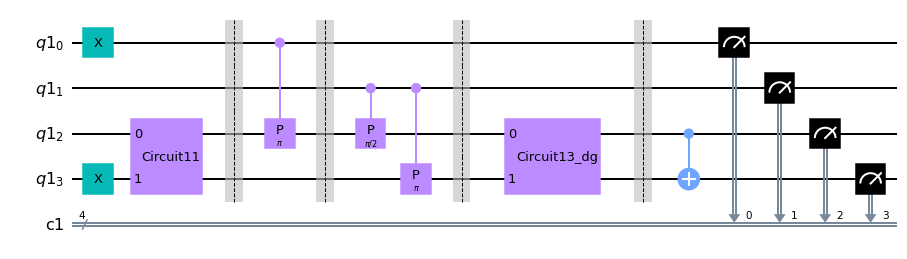

In [9]:
qct = QuantumCircuit(qt,ct)
qct.x(0)
#qct.x(1)
#qct.x(2)
qct.x(3)
#two_complament(qct,2,[0,1])
#two_complament(qct,2,[2,3])
circt = qft(QuantumCircuit(2),2)
qct.append(circt,[2,3])
qct.barrier()
phit1 = 2*np.pi*1/(2**1) 
phit2 = 2*np.pi*1/(2**2)
#phit3 = 2*np.pi*1/(2**3)
qct.cp(phit1,0,2)#.inverse()
qct.barrier()
#qct.crz(phit1,0,3).inverse()
#qct.barrier()
qct.cp(phit2,1,2)#.inverse()
qct.cp(phit1,1,3)#.inverse()
qct.barrier()
qct = inverse_qft(qct,2,[2,3])
#qct.append(qftdgreal(2),[2,3])
qct.barrier()
#qct.reset([3])
#qct2.initialize([1,0],3)
qct.cx(2,3)
#two_complament(qct,2,[2,3])
#qct.measure([0,1],[0,1])
#qct.measure([2,3],[2,3])
qct.measure([0,1,2,3], [0,1,2,3])
qct.draw('mpl')

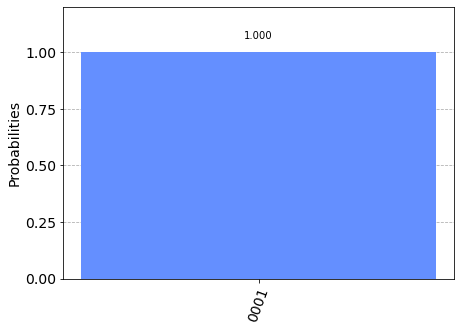

In [10]:
results = execute(qct,backend = backend_sim, shots = N_shots).result()
#abs(results.get_statevector())
counts = results.get_counts()
plot_histogram(counts)

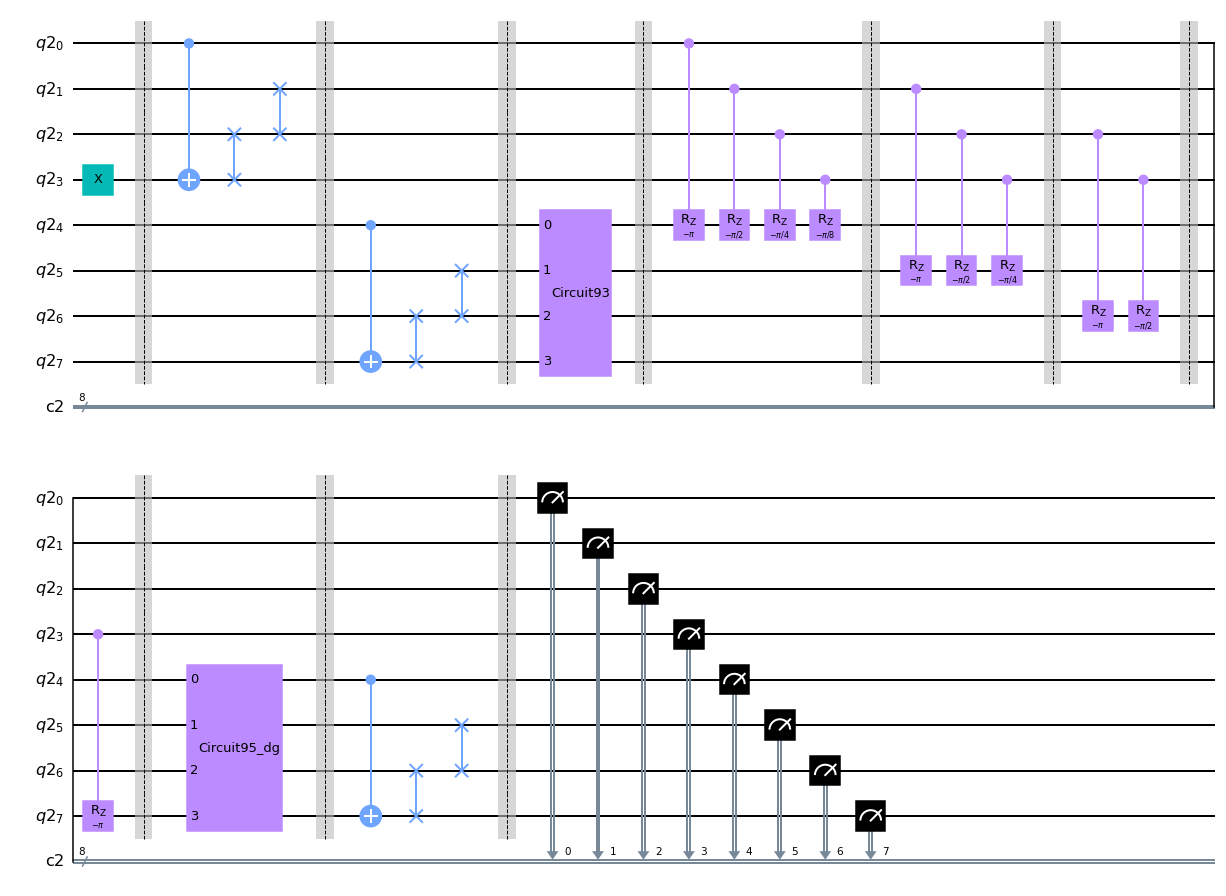

In [11]:
qct2 = QuantumCircuit(qt2,ct2)
#qct2.x(0)
#qct2.x(1)
#qct2.x(2)
qct2.x(3)
#qct2.x(4)
#qct2.x(5)
#qct2.x(6)
#qct2.x(7)

qct2.barrier()



#qct2.initialize([1,0],0)
#qct2.initialize([1,0],1)
#qct2.initialize([1,0],2)
#qct2.initialize([0,1],3)
#qct2.initialize([1,0],4)
#qct2.initialize([1,0],5)
#qct2.initialize([1,0],6)
#qct2.initialize([1,0],7)
#two_complament(qct,2,[0,1])
#two_complament(qct,2,[2,3])
qct2.cx(0,3)
qct2.swap(2,3)
qct2.swap(1,2)
qct2.barrier()

qct2.cx(4,7)
qct2.swap(6,7)
qct2.swap(5,6)
qct2.barrier()
circt2 = qft(QuantumCircuit(4),4)
qct2.append(circt2,[4,5,6,7])
qct2.barrier()
phit1 = -2*np.pi*(1/(2**1)) 
phit2 = -2*np.pi*(1/(2**2))
phit3 = -2*np.pi*(1/(2**3))
phit4 = -2*np.pi*(1/(2**4))
#phit3 = 2*np.pi*1/(2**3)
qct2.crz(phit1,0,4)#.inverse()
qct2.crz(phit2,1,4)#.inverse()
qct2.crz(phit3,2,4)#.inverse()
qct2.crz(phit4,3,4)#.inverse()
qct2.barrier()
qct2.crz(phit1,1,5)#.invers
qct2.crz(phit2,2,5)#.inverse()
qct2.crz(phit3,3,5)#.inverse()
qct2.barrier()
qct2.crz(phit1,2,6)#.inverse()
qct2.crz(phit2,3,6)#.inverse()
qct2.barrier()
qct2.crz(phit1,3,7)#.inverse()
qct2.barrier()
qct2 = inverse_qft(qct2,4,[4,5,6,7])
#qct.append(qftdgreal(2),[2,3])
qct2.barrier()
#qct.reset([7])
#qct2.initialize([1,0],7)
qct2.cx(4,7)
qct2.swap(6,7)
qct2.swap(5,6)
qct2.barrier()
#two_complament(qct,4,[4,5,6,7])

qct2.measure([0,1,2,3,4,5,6,7], [0,1,2,3,4,5,6,7])
qct2.draw('mpl')

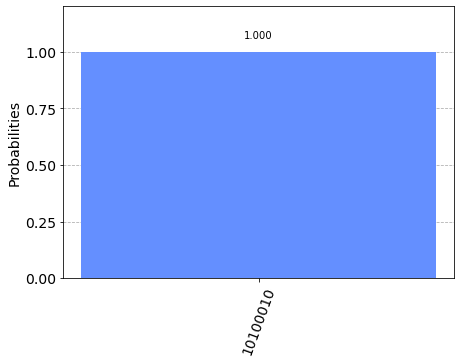

In [12]:
results2 = execute(qct2,backend = backend_sim, shots = N_shots).result()
#results.get_statevector()
counts2 = results2.get_counts()
plot_histogram(counts2)

# How to multiple two numbers and add another

This section will be to show how to multiply ab and then add c such that $|a, b, c\rangle \rightarrow |a,b,ab + c \  mod (2^n)\rangle$

In [ ]:
qt2 = QuantumRegister(6) 
ct2 = ClassicalRegister(6)

In [ ]:
def rdg_two_ctrl(phi,qc,qb,qbc1,qbc2):
    qcrc1 = QuantumCircuit(1,name='R_dg')
    qcrc1.rz(phi,0).inverse()
    custom = qcrc1.to_gate().control(2)
    return qc.append(custom,[qb,qbc1,qbc2]) 

In [ ]:
qct2 = QuantumCircuit(qt2,ct2)
qct2.initialize([1,0],0)
qct2.initialize([0,1],1)
qct2.initialize([1,0],2)
qct2.initialize([0,1],3)
qct2.initialize([0,1],4)
qct2.initialize([0,1],5)
qct2.append(qftreal(2),[4,5])
qct2.barrier()


phit1 = 2*np.pi*1/(2**1) 
phit2 = 2*np.pi*1/(2**2)

rdg_two_ctrl(phit1,qct2,1,3,4)
rdg_two_ctrl(phit2,qct2,1,3,5)
rdg_two_ctrl(phit1,qct2,1,2,5)
rdg_two_ctrl(phit1,qct2,0,3,5)


#qct2.crz(phit1,1,2).inverse()
#qct2.crz(phit2,1,3).inverse()
qct2.barrier()
qct2.append(qftreal(2).inverse(),[4,5])

#qct2.barrier()
##qct.measure([0,1],[0,1])
##qct.measure([2,3],[2,3])
qct2.measure([0,1,2,3,4,5], [0,1,2,3,4,5])
qct2.draw('mpl')

In [ ]:
results2 = execute(qct2,backend = backend_sim, shots = N_shots).result()
#results.get_statevector()
counts2 = results2.get_counts()
plot_histogram(counts2)

In [ ]:
(1*1+-1) % 2**2

In [ ]:
def four_number_addition_gate(circuit,c,t1,t2):
    # a + b
    circuit.append(qftreal(2),[2,3])
    phi_1 = 2*np.pi*c/2
    phi_2 = 2*np.pi*c/(4)
    circuit.append(two_controlled_rotation_dagger_gate(0,phi_1),[t1,2,3])
    circuit.append(two_controlled_rotation_dagger_gate(phi_1,phi_2),[t2,2,3])
    circuit.append(qftdgreal(2),[2,3])
    return circuit

In [ ]:
qc1 = QuantumCircuit(q_2)
qc1.initialize([1,0],0)
qc1.initialize([1,0],1)
qc1.initialize([1,0],2)
qc1.initialize([1,0],3)
qc1.initialize([1,0],4)
qc1.initialize([1,0],5)
qc1.initialize([1,0],6)
qc1.initialize([1,0],7)
qc1.initialize([1,0],8)
qc1.initialize([1,0],9)
qc1.initialize([1,0],10)
qc1.initialize([1,0],11)
qc1.initialize([1,0],12)
qc1.initialize([1,0],13)
qc1.initialize([1,0],14)
qc1.initialize([1,0],15)
qc1.append(qftreal(4),[8,9,10,11])
qc1.append(qftreal(4),[12,13,14,15])



qc1.append(qftdgreal(4),[8,9,10,11])
qc1.append(qftdgreal(4),[12,13,14,15])
qc1.draw('mpl')

# Classical Solver

In [ ]:
def classical_way(t,z):
    #y is a vector [u1(0),u2(0)]
    x,y = z
    dydt = [y,-x]
    return dydt

In [ ]:
y0 = [0,-1]
time = np.linspace(0,7,N_time)
sol = solve_ivp(classical_way, [0,7],y0, method='RK45',dense_output=True, t_eval=time)

In [ ]:
plt.plot(sol.t, sol.y[0, :], '-b', label='$u_1$(t)')
plt.plot(sol.t, sol.y[1, :], '-g', label='$u_2$(t)')
#plt.plot(time, z.T)
plt.legend(loc='best')
#plt.legend(['$u_1$(t)', '$u_2$(t)'], shadow=True)
plt.xlabel('t')
plt.ylim(-3,3)
plt.xlim(0,7)
plt.grid()
plt.show()

We are gonig to try to reproduce the paper's example such that $u_1(t = 0) = 0$ and $u_2(t = 0) = -1$. This involes knowing the address of a number, for example, the number 6 in binary form is 110. Thus, to represent a number in a quantum circuit, we need 3 qubits prepared in the state $|1\rangle \otimes |1\rangle \otimes |0\rangle$.

To include negative numbers and q amount of digits after the decimal point, we need to shift $|a\rangle$ by $2^q$ such that a = $-2^{n-1}a_{n-1} + 2^{n-2}a_{n-2} + ... + 2^{-1}a_0$. This is known as two's complament formalism. The q shift transforms a binary bit into a two's complament bit where, if q = 1, $|1110\rangle = -2.0$ and ignoring the $a_0$ term. 


The initial condition for a 4bit circuit in two's complament form is $|u_1(t = 0)\rangle = |0000\rangle$ and $|u_2(t = 0)\rangle = |1111\rangle$.

In [ ]:
def fourbittwocomplament(circuit):
    circuit.initialize([1,0],4)
    circuit.cnot(1,4)
    circuit.swap(3,4)
    circuit.swap(2,3)
    return circuit
    

Notes: 